# Import Library & Set Globals

In [2]:
%load_ext jupyter_black

# base
import os
import sys
import warnings
import logging
import pickle

# data manipulation
import pickle
import pandas as pd
import itables
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# single cell
import scanpy as sc
import decoupler as dc
import gseapy as gp

itables.init_notebook_mode(connected=True)  # Use connected=False for offline use
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", pd.errors.DtypeWarning)
warnings.simplefilter("ignore", pd.errors.PerformanceWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# custom
from single_cell.R import *
from single_cell.preprocess import *
from single_cell.plot import *
from single_cell.analysis import *
from spatial_seq.plot import *
from utils import *

converter = get_converter()

# R_preload()
%load_ext rpy2.ipython

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.base import spmatrix


In [3]:
%matplotlib inline
study = "paper_processed_FULL"
R_converted = False

CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"
DOUBLETMETHODS = ["scDblFinder", "DoubletFinder", "doubletdetection", "scrublet"]

# Get all data

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_leiden1"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
adata = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# order categories
order_obs(
    adata,
    "Identifier",
    [
        "GSM7747185-LFD_eWAT",
        "GSM7747187-HFD_eWAT",
        "GSM7747186-LFD_iWAT",
        "GSM7747188-HFD_iWAT",
    ],
)
order_obs(
    adata,
    "Groups",
    [
        "GSM7747185-LFD_eWAT",
        "GSM7747187-HFD_eWAT",
        "GSM7747186-LFD_iWAT",
        "GSM7747188-HFD_iWAT",
    ],
)
order_obs(adata, "Experiment", ["GSM7747185", "GSM7747186", "GSM7747187", "GSM7747188"])
order_obs(adata, "Condition", ["LFD", "HFD"])
order_obs(adata, "Sample Type", ["eWAT", "iWAT"])

In [ ]:
# # save
# annotation = "manDoublet-seuratV3-harmony-annotated_leiden1"
# savedir = os.path.join(DATADIR,'processed',study,'py', '3_annotated')
# adata.write(os.path.join(savedir,f'{annotation}.h5ad'))

# Macrophage prep

### Subset

In [ ]:
# subset
adata_macros = adata[adata.obs["cell_type"] == "Macrophage"].copy()
del adata_macros.uns, adata_macros.varm, adata_macros.obsp
sc.pp.filter_cells(adata_macros, min_genes=200)
sc.pp.filter_genes(adata_macros, min_cells=5)
Visualize(adata_macros, "_macro")

In [ ]:
# integration check
f = plt.figure(figsize=(18, 12), layout="constrained")
check_integration(
    adata_macros,
    "Groups",
    f,
    embeddings=["UMAP_macro", "LocalMAP_macro"],
    nrow=2,
    ncol=2,
)

### Clusters

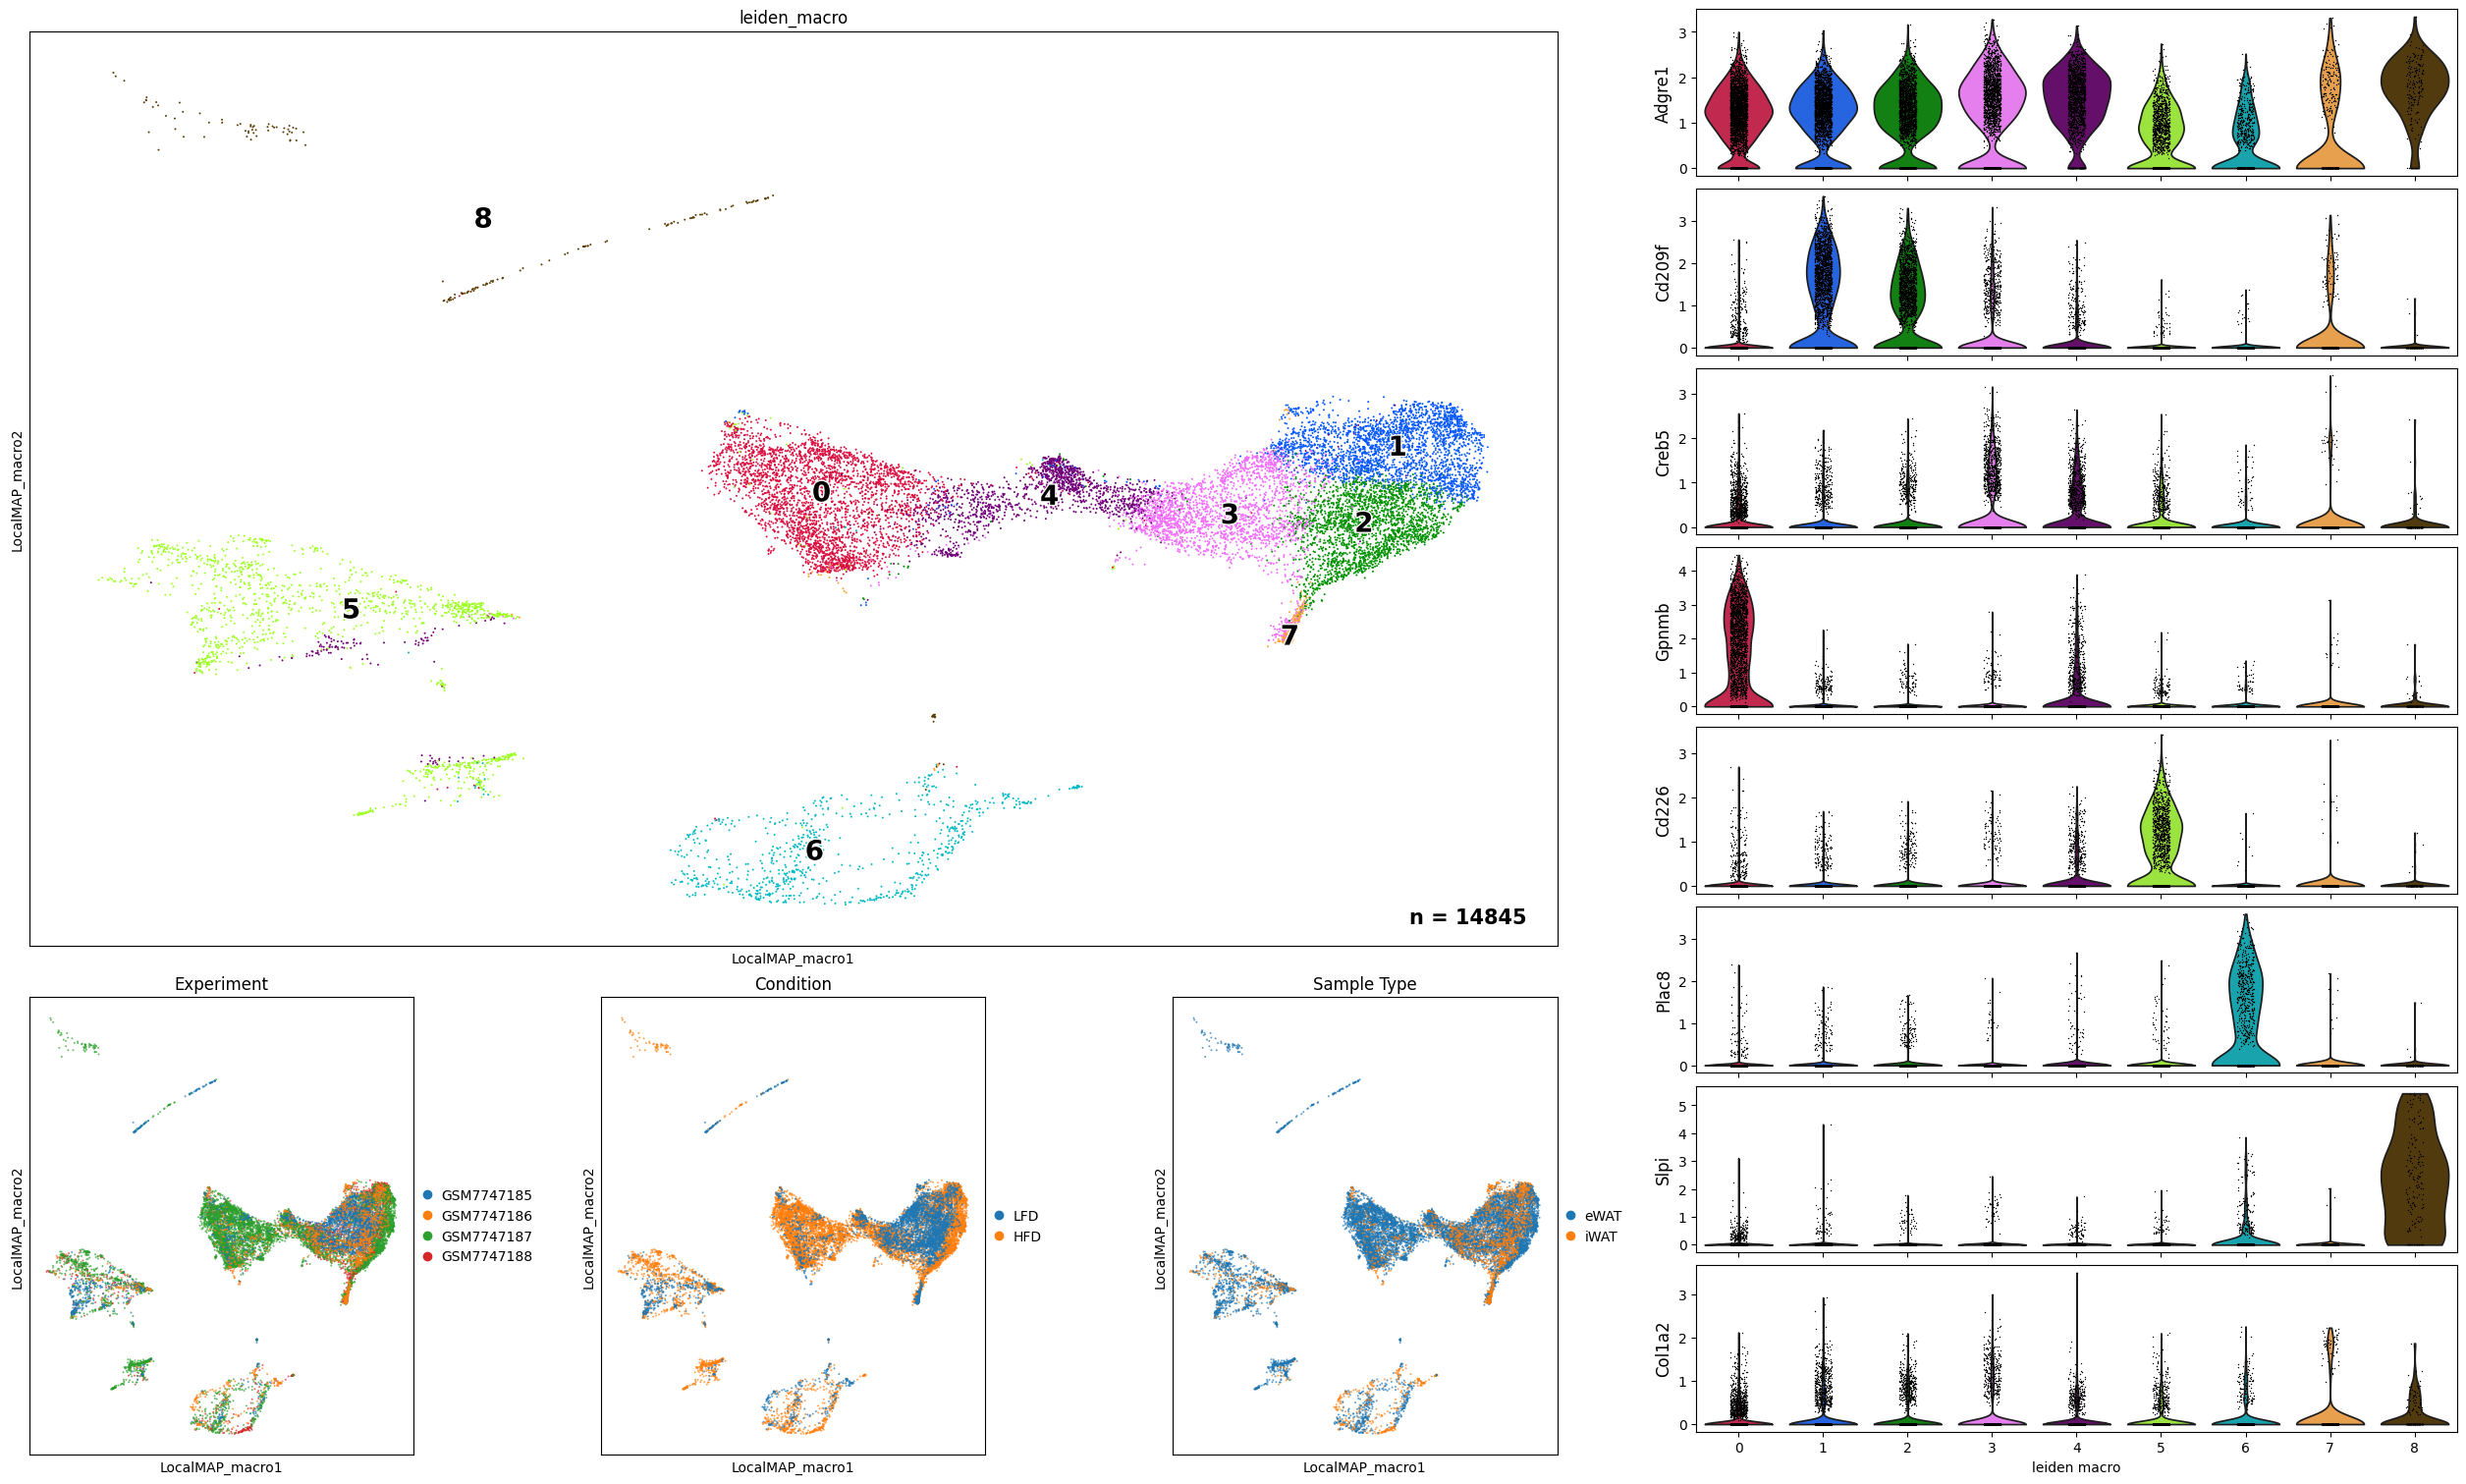

In [ ]:
cluster = False
key = "leiden_macro"
embedding = "LocalMAP_macro"  # "UMAP_macro"

# clsuter
if cluster is True:
    sc.tl.leiden(adata_macros, resolution=0.5, key_added="leiden_macro")

# figure prep
cluster_c = color_gen(adata_macros.obs[key])
f = plt.figure(figsize=(25, 15), layout="constrained")
sf = f.subfigures(1, 2, width_ratios=[2, 1])

# Large LocalMAP plot
axs = sf[0].subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

ax = sf[0].add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
ax.annotate(
    f"n = {adata_macros.shape[0]}",
    size=15,
    fontweight="bold",
    xy=(0.98, 0.02),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="bottom",
)
ax = sf[0].add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=["Groups"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_macros.obs["Groups"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_macros.obs["Condition"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 2])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_macros.obs["Sample Type"]).to_list(),
)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
plot_violinplot(adata_macros, markers, key, sf[1])

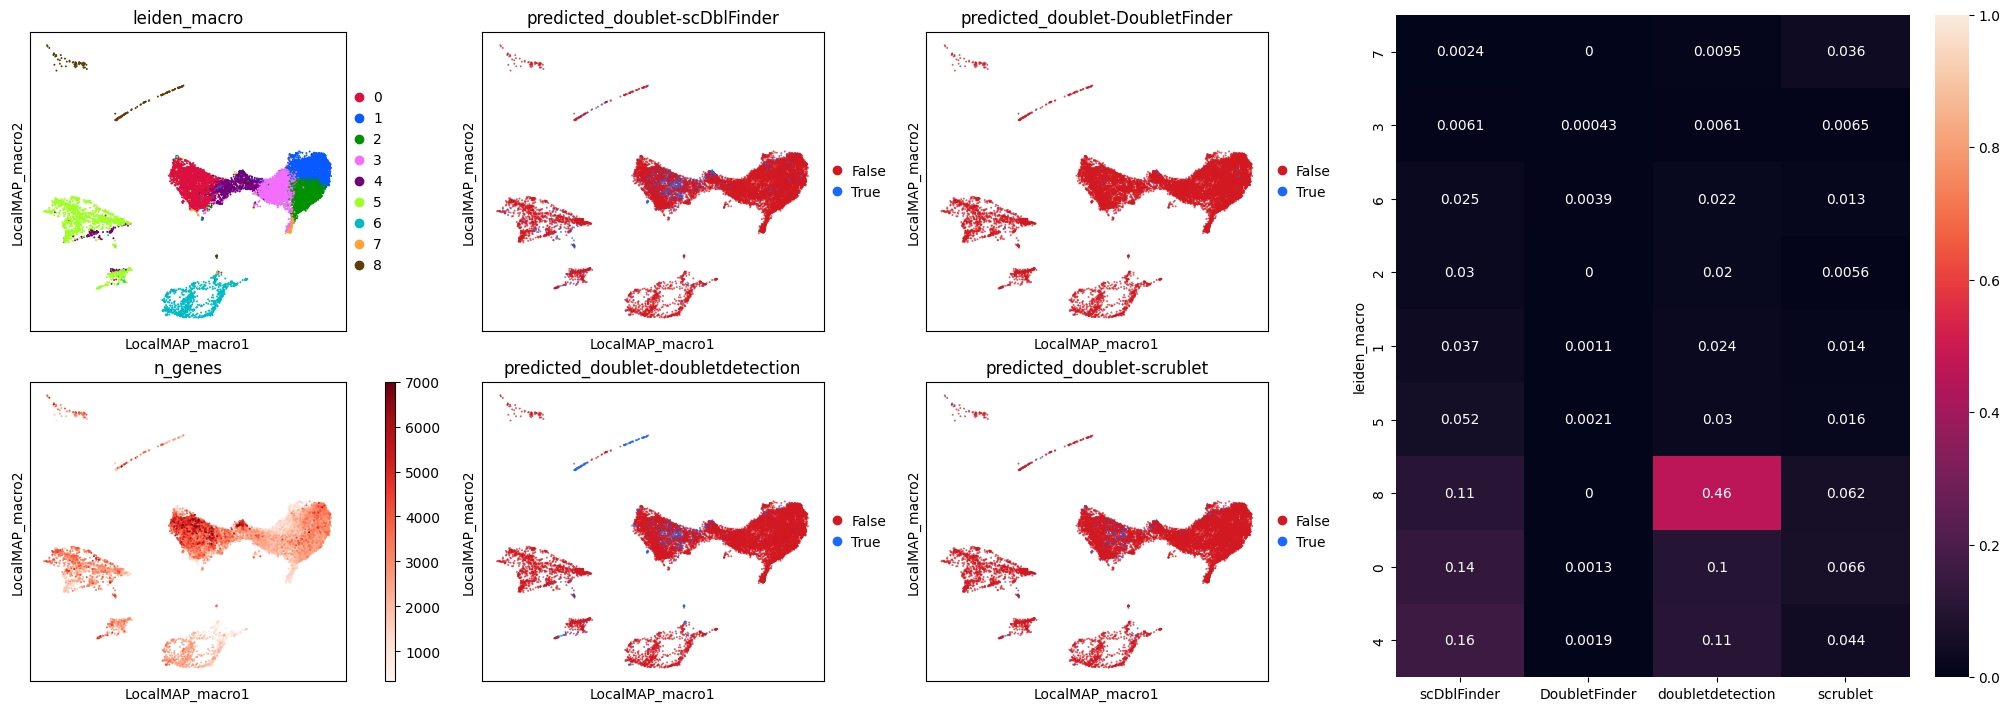

In [6]:
# doublet check
checkDoublets(adata_macros, "LocalMAP_macro", "leiden_macro")

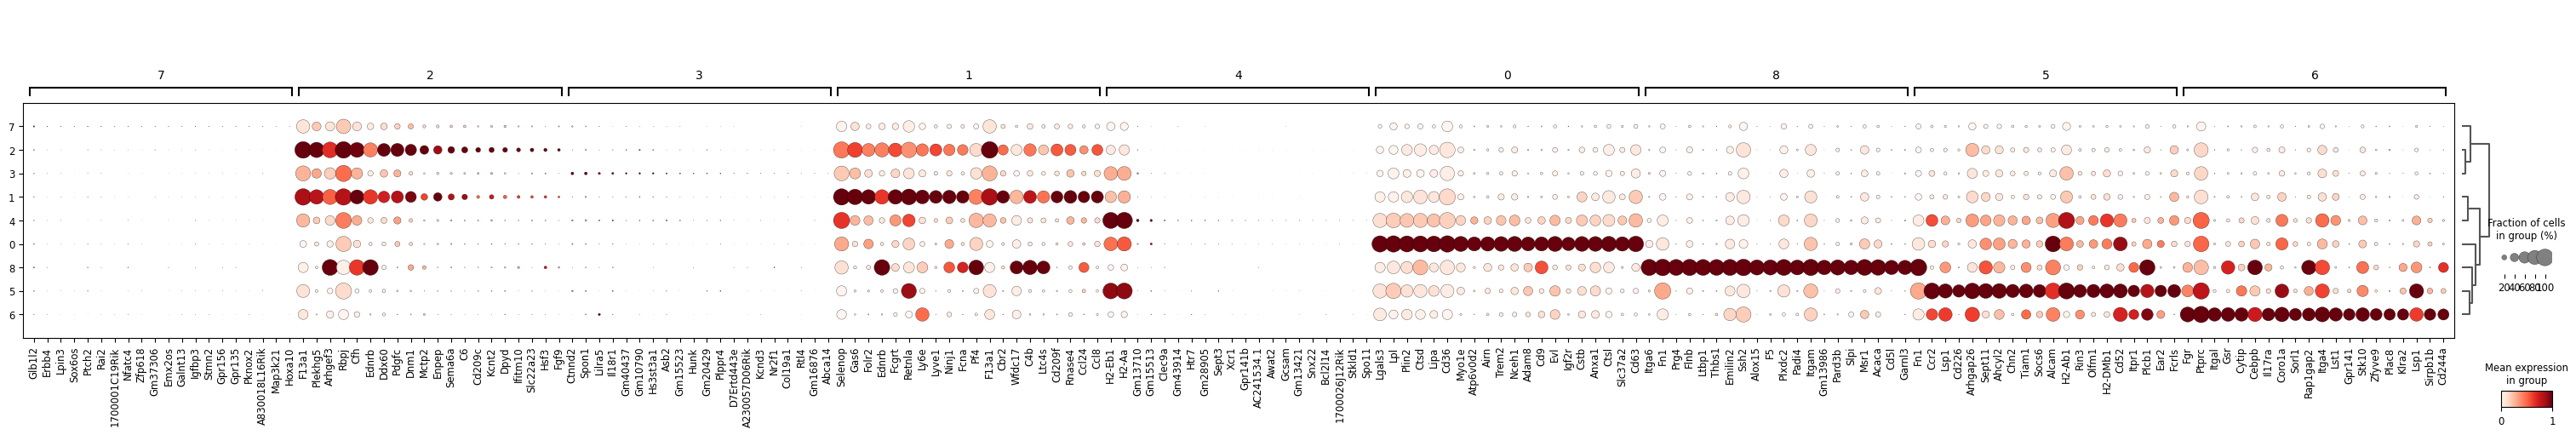

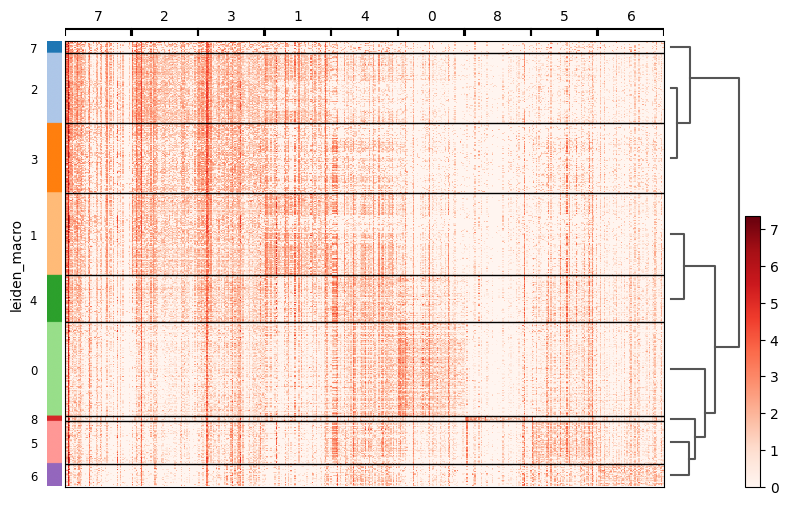

In [ ]:
# original subclusters
de_key = "de_macro_pre"
cluster_key = "leiden_macro"

clear_uns(adata_macros, cluster_key)
sc.tl.rank_genes_groups(
    adata_macros,
    groupby=cluster_key,
    key_added=de_key,
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)
f, ax = plt.subplots(1, 1, figsize=(30, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_macros,
    groupby=cluster_key,
    key=de_key,
    standard_scale="var",
    n_genes=20,
    min_logfoldchange=2,
    ax=ax,
)
sc.pl.rank_genes_groups_heatmap(
    adata_macros, key=de_key, groupby=[cluster_key], layer="normalized", n_genes=50
)

# Cluster Regrouping

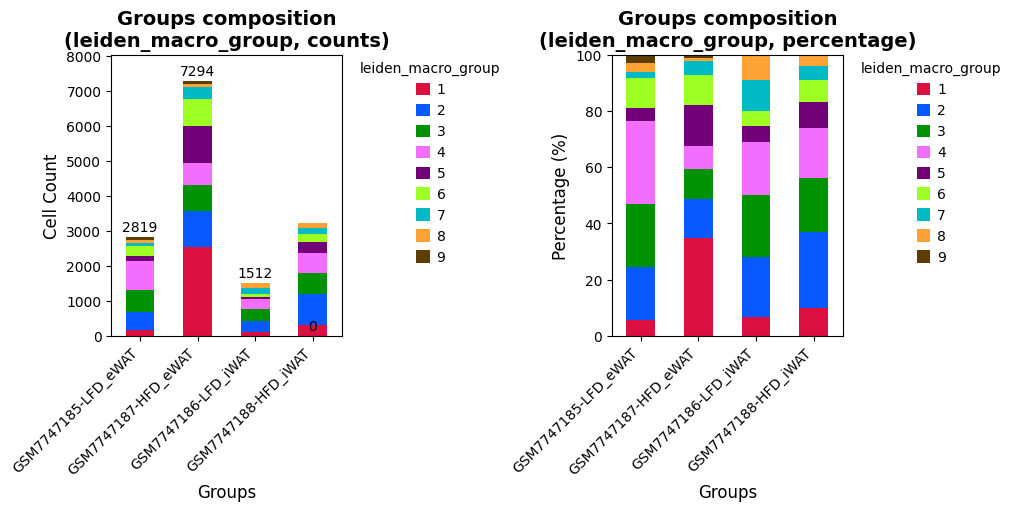

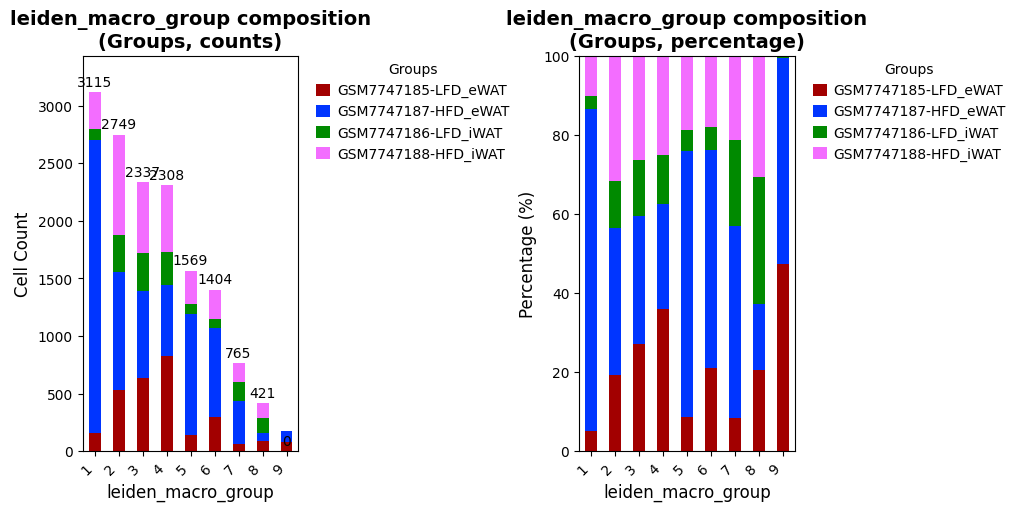

In [ ]:
# reannotate
old_cluster_key = "leiden_macro"
cluster_key = f"{old_cluster_key}_group"
group_key = "Groups"

adata_macros.obs[cluster_key] = (
    adata_macros.obs[old_cluster_key]
    .map(
        {
            "0": 1,
            "1": 2,
            "2": 3,
            "3": 4,
            "4": 5,
            "5": 6,
            "6": 7,
            "7": 8,
            "8": 9,
            "9": "remove",
            "10": "remove",
        }
    )
    .astype(str)
)

# reannotate
order_obs(
    adata_macros,
    cluster_key,
    pd.Series(np.sort(adata_macros.obs[cluster_key].unique())).astype(str),
)

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_macros, group_key, cluster_key, pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_macros, group_key, cluster_key, pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_macros, cluster_key, group_key, pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_macros, cluster_key, group_key, pct=True, ax=axs[1])

pd.crosstab(adata_macros.obs[cluster_key], adata_macros.obs[group_key])

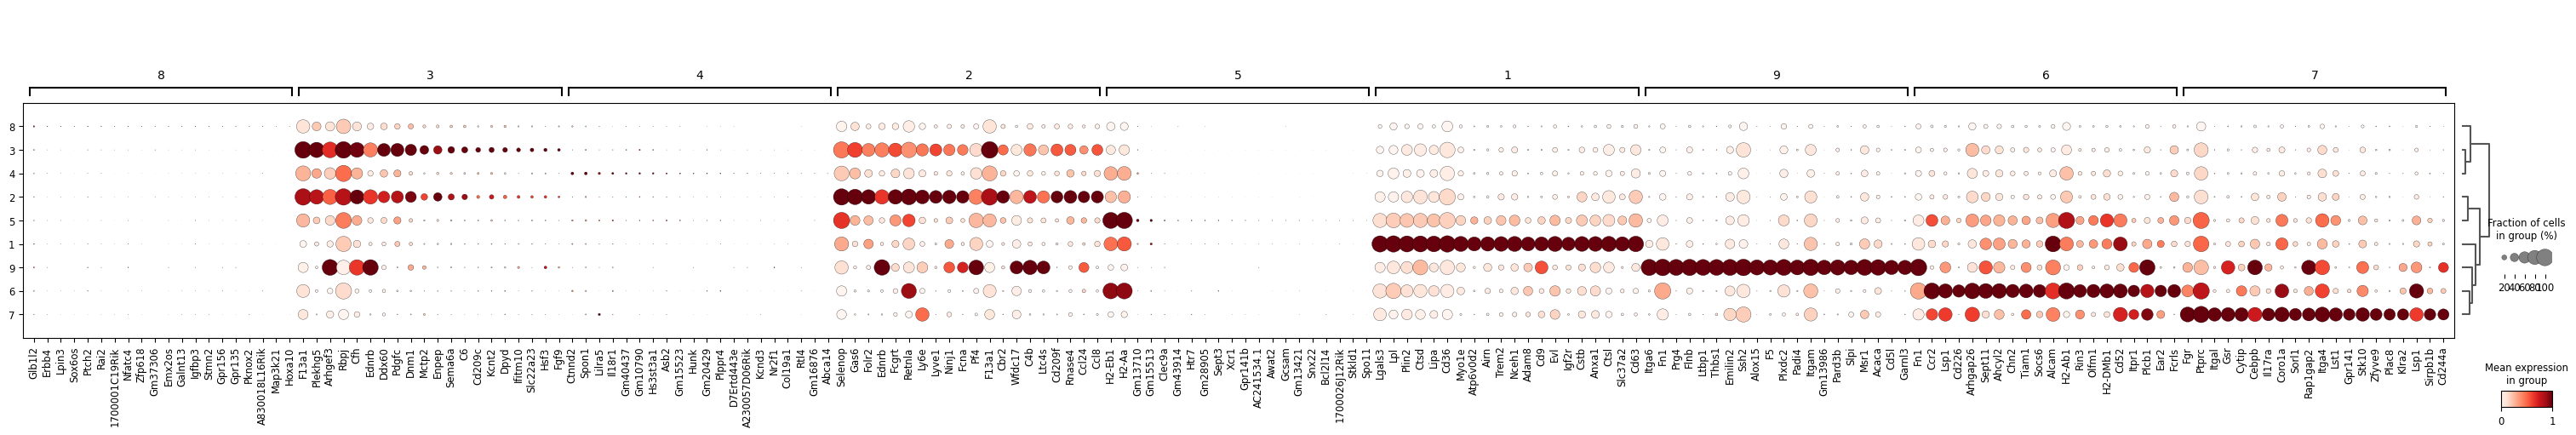

categories: 0, 1, 2, etc.
var_group_labels: 1, 2, 3, etc.


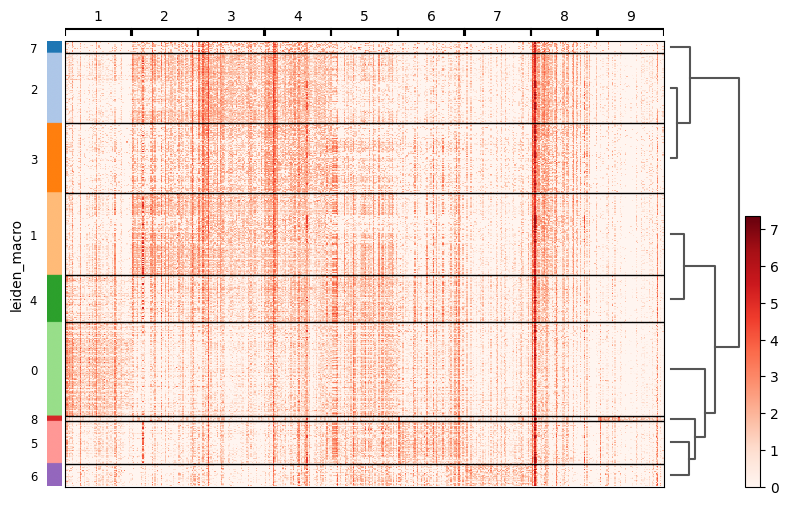

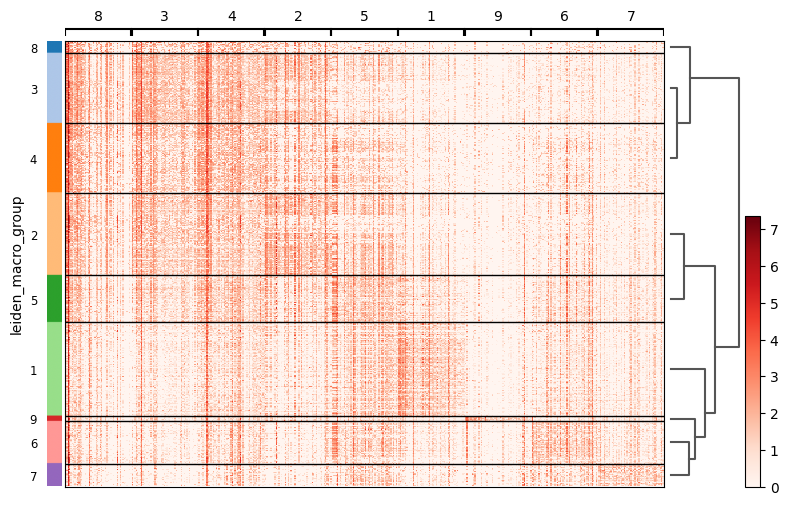

In [ ]:
group_key = "leiden_macro_group"
de_key = "de_macro"

# clean metadata
clear_uns(adata_macros, group_key)

# run DEGs
sc.tl.rank_genes_groups(
    adata_macros,
    groupby=group_key,
    key_added=de_key,
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

# plot DEGs dotplot
f, ax = plt.subplots(1, 1, figsize=(30, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_macros,
    groupby=group_key,
    key=de_key,
    standard_scale="var",
    n_genes=20,
    min_logfoldchange=2,
    ax=ax,
)

# plot DEGs heatmap
sc.pl.rank_genes_groups_heatmap(
    adata_macros, key=de_key, groupby=group_key, layer="normalized", n_genes=50
)

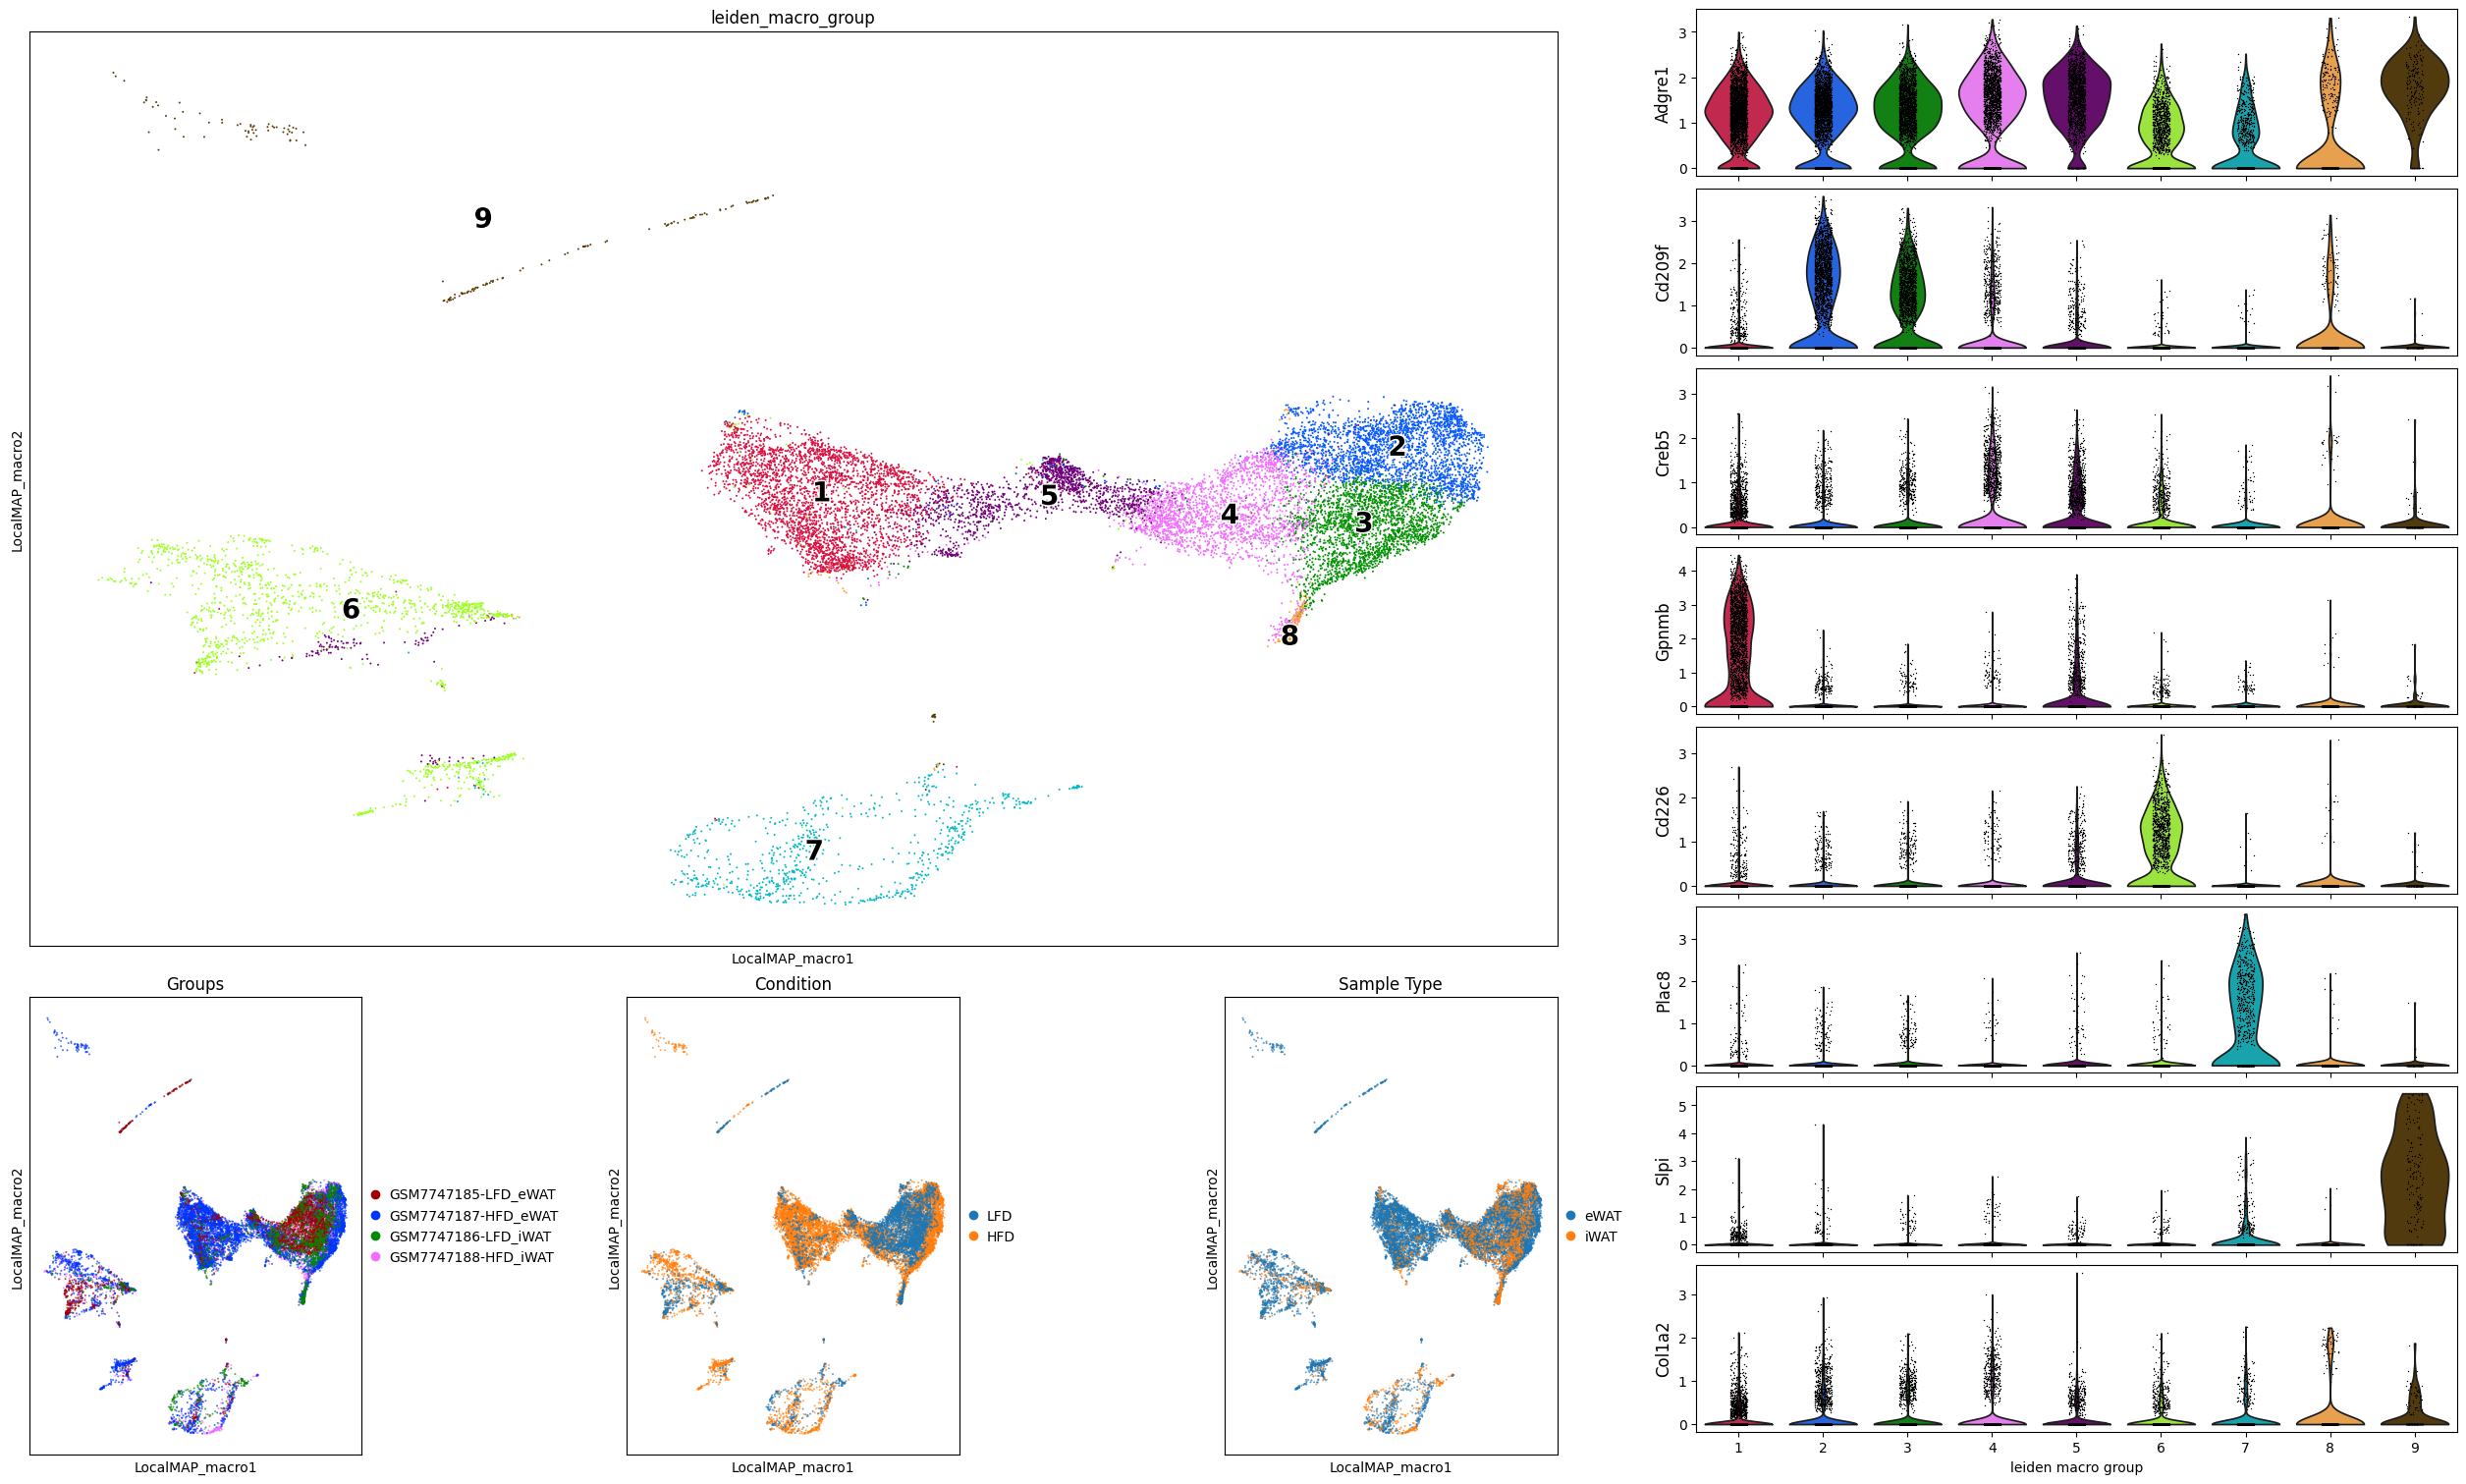

In [ ]:
key = "leiden_macro_group"
embedding = "LocalMAP_macro"  # "UMAP_macro"

# figure prep
cluster_c = color_gen(adata_macros.obs[key])
f = plt.figure(figsize=(25, 15), layout="constrained")
sf = f.subfigures(1, 2, width_ratios=[2, 1])

axs = sf[0].subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
ax = sf[0].add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
ax = sf[0].add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=["Groups"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_macros.obs["Groups"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_macros.obs["Condition"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 2])
sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_macros.obs["Sample Type"]).to_list(),
)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
plot_violinplot(adata_macros, markers, key, sf[1])

In [ ]:
# relevant subsets
ewat_macros = adata_macros[adata_macros.obs["Sample Type"] == "eWAT"].copy()
lfd_ewat_macros = ewat_macros[ewat_macros.obs["Condition"] == "LFD"].copy()
hfd_ewat_macros = ewat_macros[ewat_macros.obs["Condition"] == "HFD"].copy()

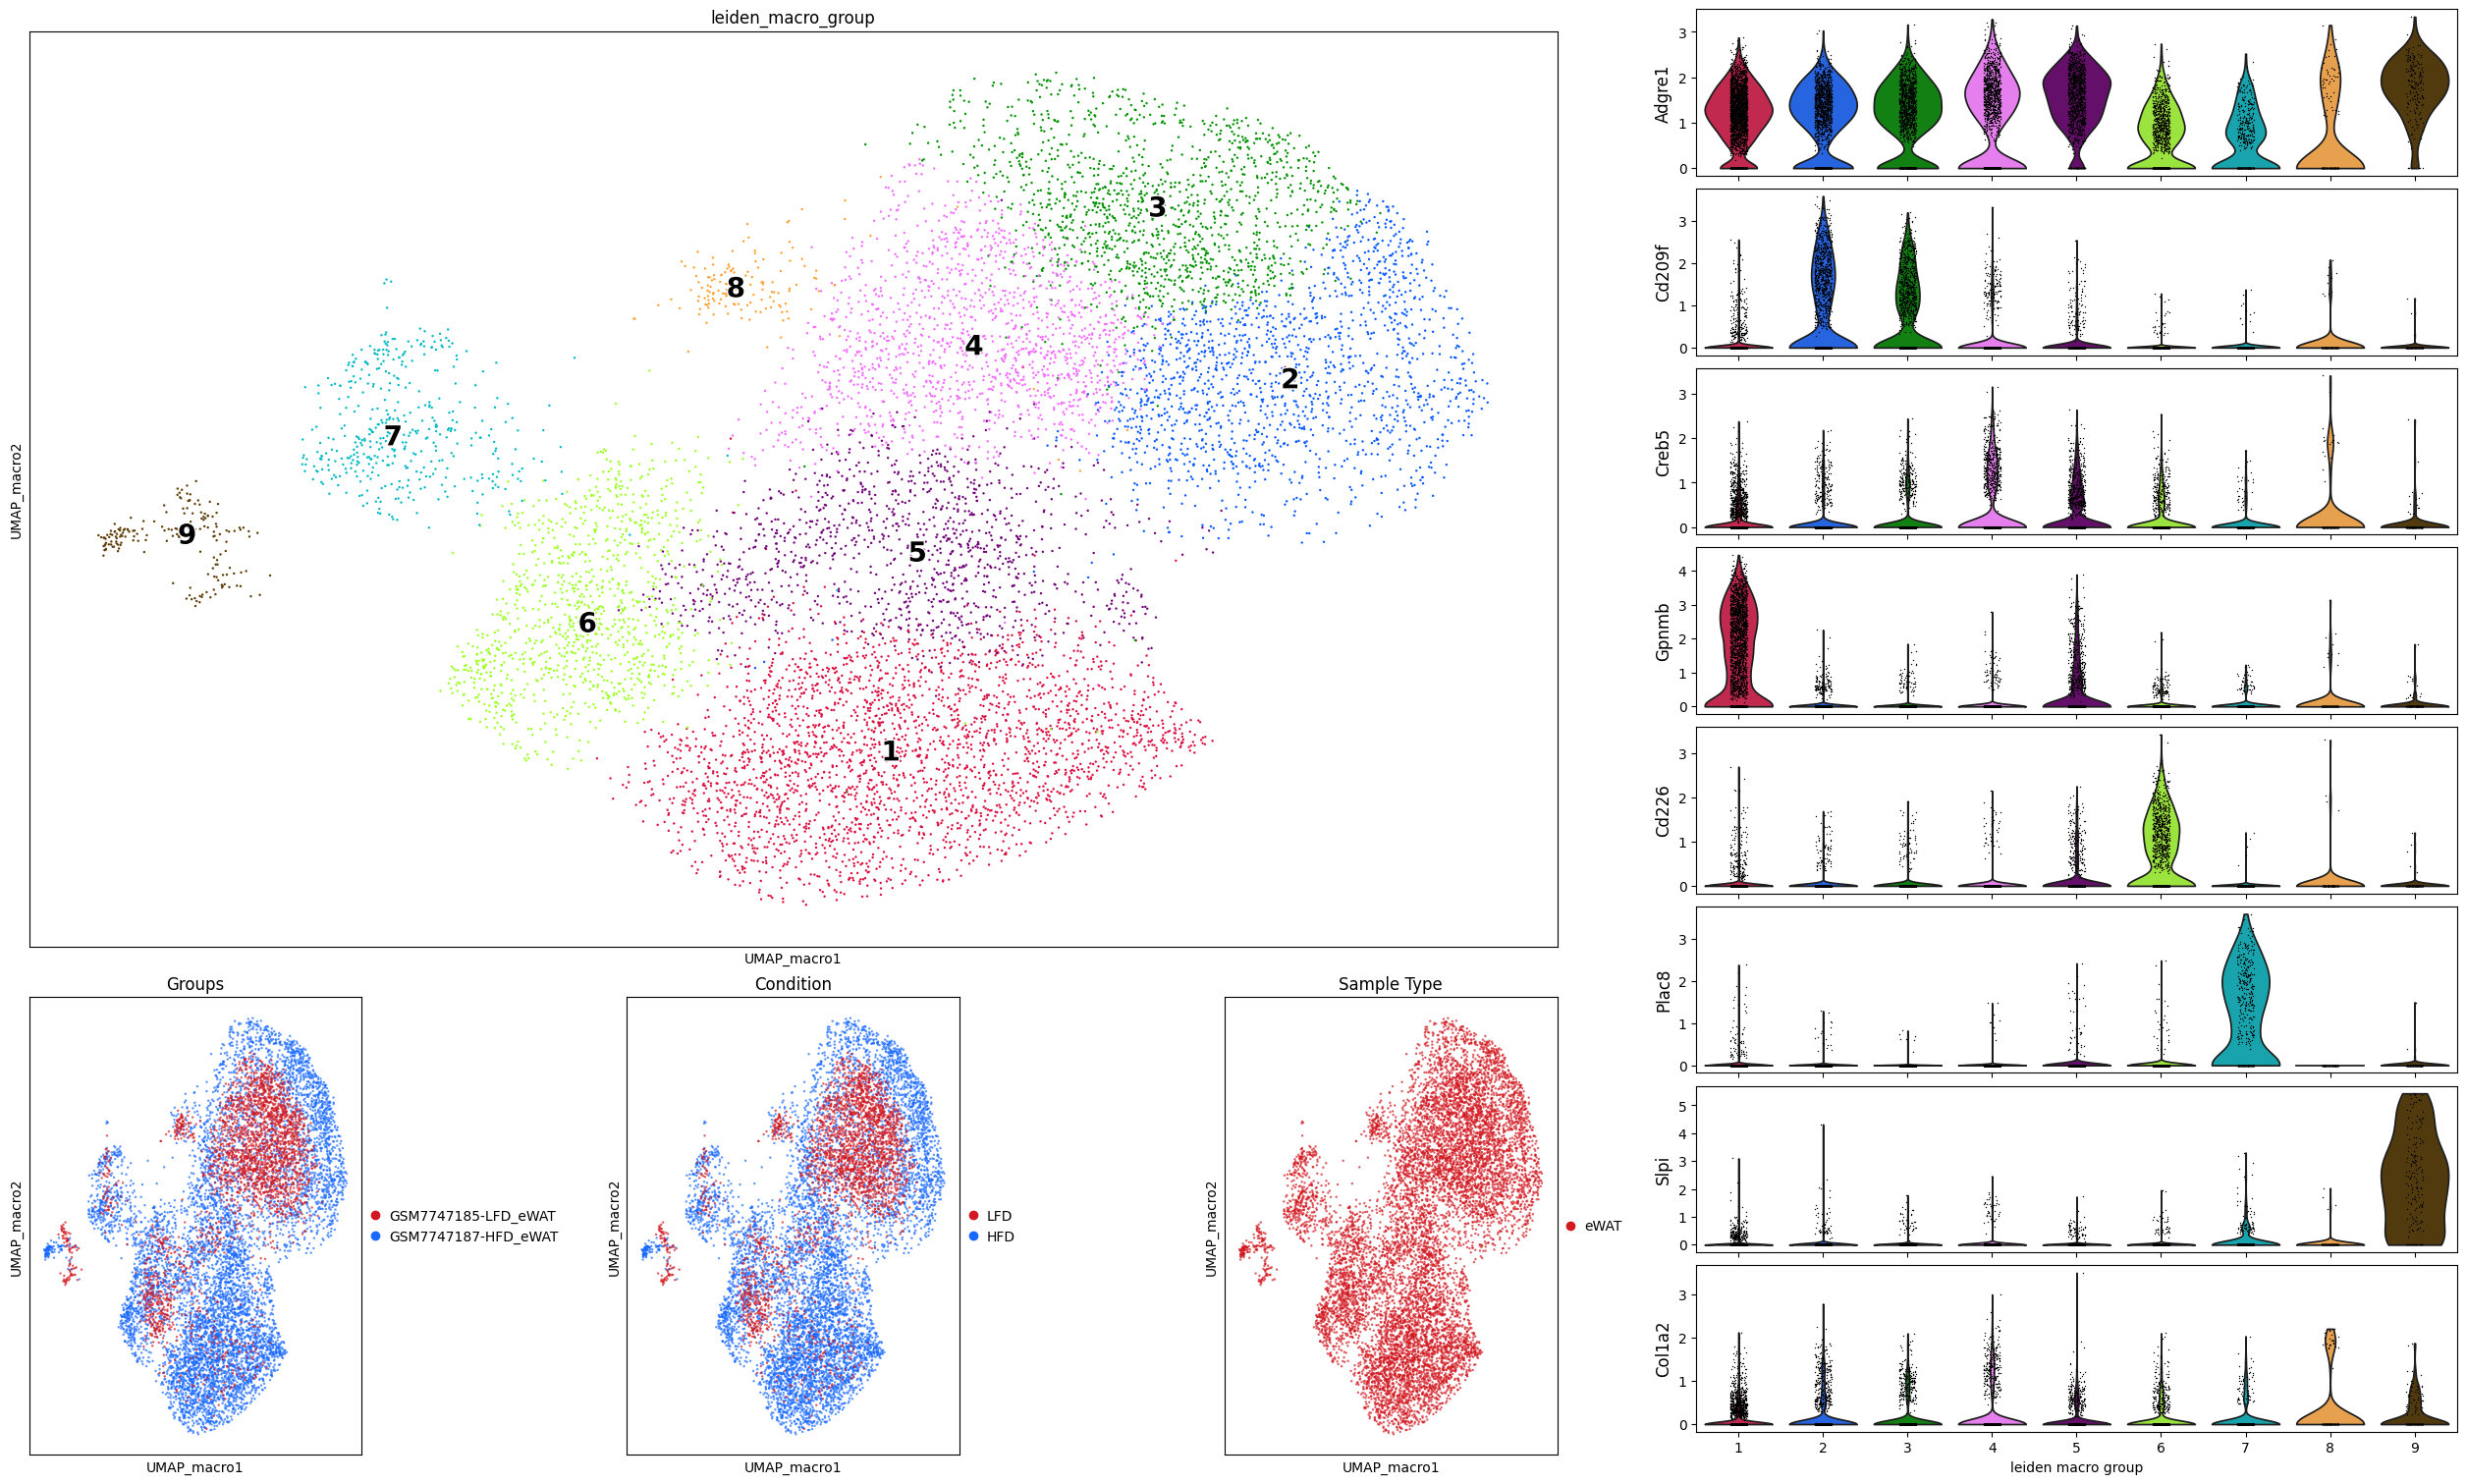

In [11]:
# figure prep
key = "leiden_macro_group"
embedding = "UMAP_macro"

cluster_c = color_gen(ewat_macros.obs[key])
f = plt.figure(figsize=(25, 15), layout="constrained")
sf = f.subfigures(1, 2, width_ratios=[2, 1])

axs = sf[0].subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
ax = sf[0].add_subplot(gs[:2, :])
sc.pl.embedding(
    ewat_macros,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
ax = sf[0].add_subplot(gs[2, 0])
sc.pl.embedding(
    ewat_macros,
    basis=embedding,
    color=["Groups"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(ewat_macros.obs["Groups"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 1])
sc.pl.embedding(
    ewat_macros,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(ewat_macros.obs["Condition"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 2])
sc.pl.embedding(
    ewat_macros,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(ewat_macros.obs["Sample Type"]).to_list(),
)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
plot_violinplot(ewat_macros, markers, key, sf[1])

# Dissecting clusters

In [29]:
# define markers
flow_markers = ["Lyve1", "H2-Ab1", "Mgl2", "Cx3cr1", "Mrc1"]

selected_markers = [
    "Lyve1",  # Lymphatic vessel endothelial hyaluronan receptor 1
    "Arg1",  # Arginase 1
    "Itgax",  # Integrin alpha X (CD11c)
    "Timd4",  # T-cell immunoglobulin and mucin domain containing 4 (TIM-4)
    "H2-Ab1",  # MHC class II (commonly H2-Ab1 for mouse)
    "Maf",  # Maf bZIP transcription factor
    "Mrc1",  # Mannose receptor C type 1 (CD206)
    "Trem2",  # Triggering receptor expressed on myeloid cells 2
    "Fn1",  # Fibronectin 1
    "Cd36",  # CD36 molecule
    "Lipa",  # Lipase A, lysosomal acid, cholesterol esterase
    "Lpl",  # Lipoprotein lipase
    "Cx3cr1",  # CX3C chemokine receptor 1
    "Siglec1",  # Also known as Cd169
    "Cd163",  # CD163 molecule
    "Retnla",  # Resistin-like alpha (RELMα)
    "Gas6",  # Growth arrest-specific 6
    "Axl",  # AXL receptor tyrosine kinase
    "Mertk",  # MERTK protein tyrosine kinase
    "Cd9",
    "Mgl2",
    "Ccr2",
    # "Tyro3",      # TYRO3 protein tyrosine kinase
]

spatial_informed_markers = [
    "Mmp12",
    "Cd9",
    "Lyz1",
    "Timd4",
    "Cd5l",
    "Arg1",
    "Il1rn",
    "Ccl9",
    "Clec4d",
    "Cx3cr1",
    "Mrc1",
    "Marco",
    "Trem2",
    "Maf1",
    "S100a4",
    "Itgax",
    "Maf",
    "H2-Ab1",
    "Cd5l",
]

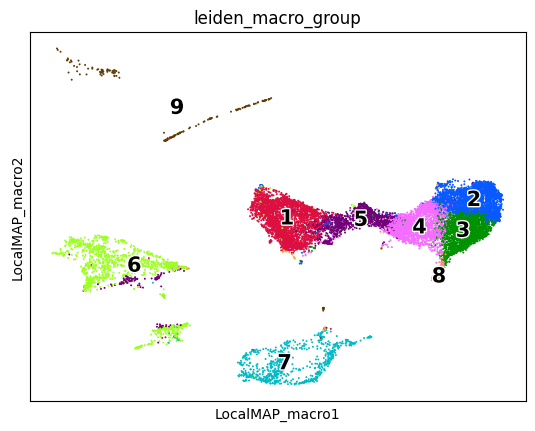

In [18]:
embedding = "LocalMAP_macro"  # "UMAP_macro"
key = "leiden_macro_group"

sc.pl.embedding(
    adata_macros,
    basis=embedding,
    color=[key],
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=15,
)

Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 1, 2, 3, etc.
var_group_labels: 1


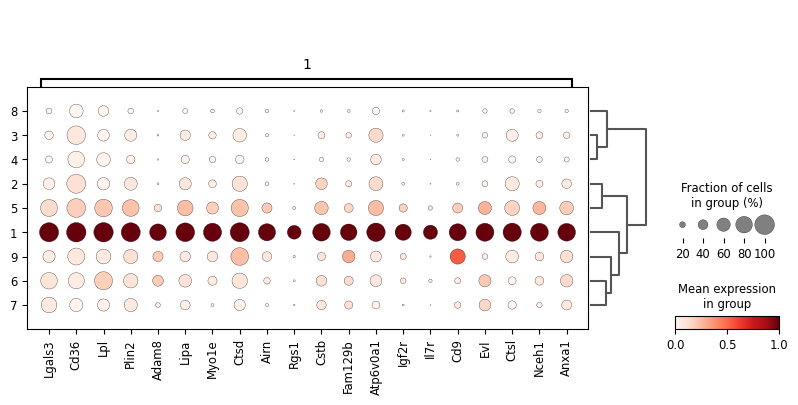

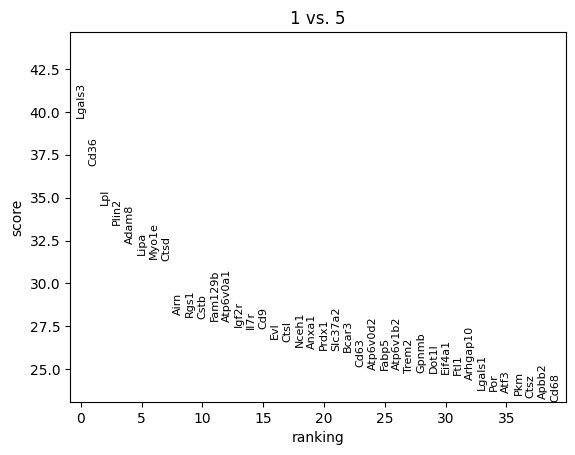

names     scores  logfoldchanges          pvals      pvals_adj
0      Lgals3  39.674278        2.439468   0.000000e+00   0.000000e+00
1        Cd36  36.828220        1.902151  6.528015e-297  6.132091e-293
2         Lpl  34.609509        2.138001  1.817497e-262  6.829064e-259
3       Plin2  33.412903        1.721667  8.905413e-245  2.788433e-241
4       Adam8  32.302711        2.756747  6.407604e-229  1.719709e-225
...       ...        ...             ...            ...            ...
5008   Atp2b1 -29.671326       -1.296044  1.800489e-193  2.601983e-190
5009   Slc9a9 -30.261215       -1.957098  3.714583e-201  5.815490e-198
5010  Serinc3 -30.635410       -1.553822  4.134311e-206  7.061027e-203
5011     Mrc1 -35.172707       -1.937288  5.227875e-271  2.455402e-267
5012     Ctsc -36.096916       -2.309534  2.535196e-285  1.587624e-281

[5013 rows x 5 columns]

In [30]:
de_key = "temp_cluster"
group_key = "leiden_macro_group"
# sc.tl.rank_genes_groups(
#     ewat_macros,
#     group_key,
#     groups=["1"],
#     reference="5",
#     method="wilcoxon",
#     key_added=de_key,
#     use_raw=False,
#     layer="normalized",
# )

sc.pl.rank_genes_groups_dotplot(
    ewat_macros,
    groups=["1"],
    key=de_key,
    standard_scale="var",
    n_genes=20,
)
sc.pl.rank_genes_groups(ewat_macros, groups=["1"], n_genes=40, key=de_key)
sc.get.rank_genes_groups_df(ewat_macros, group=None, key=de_key, pval_cutoff=0.05)

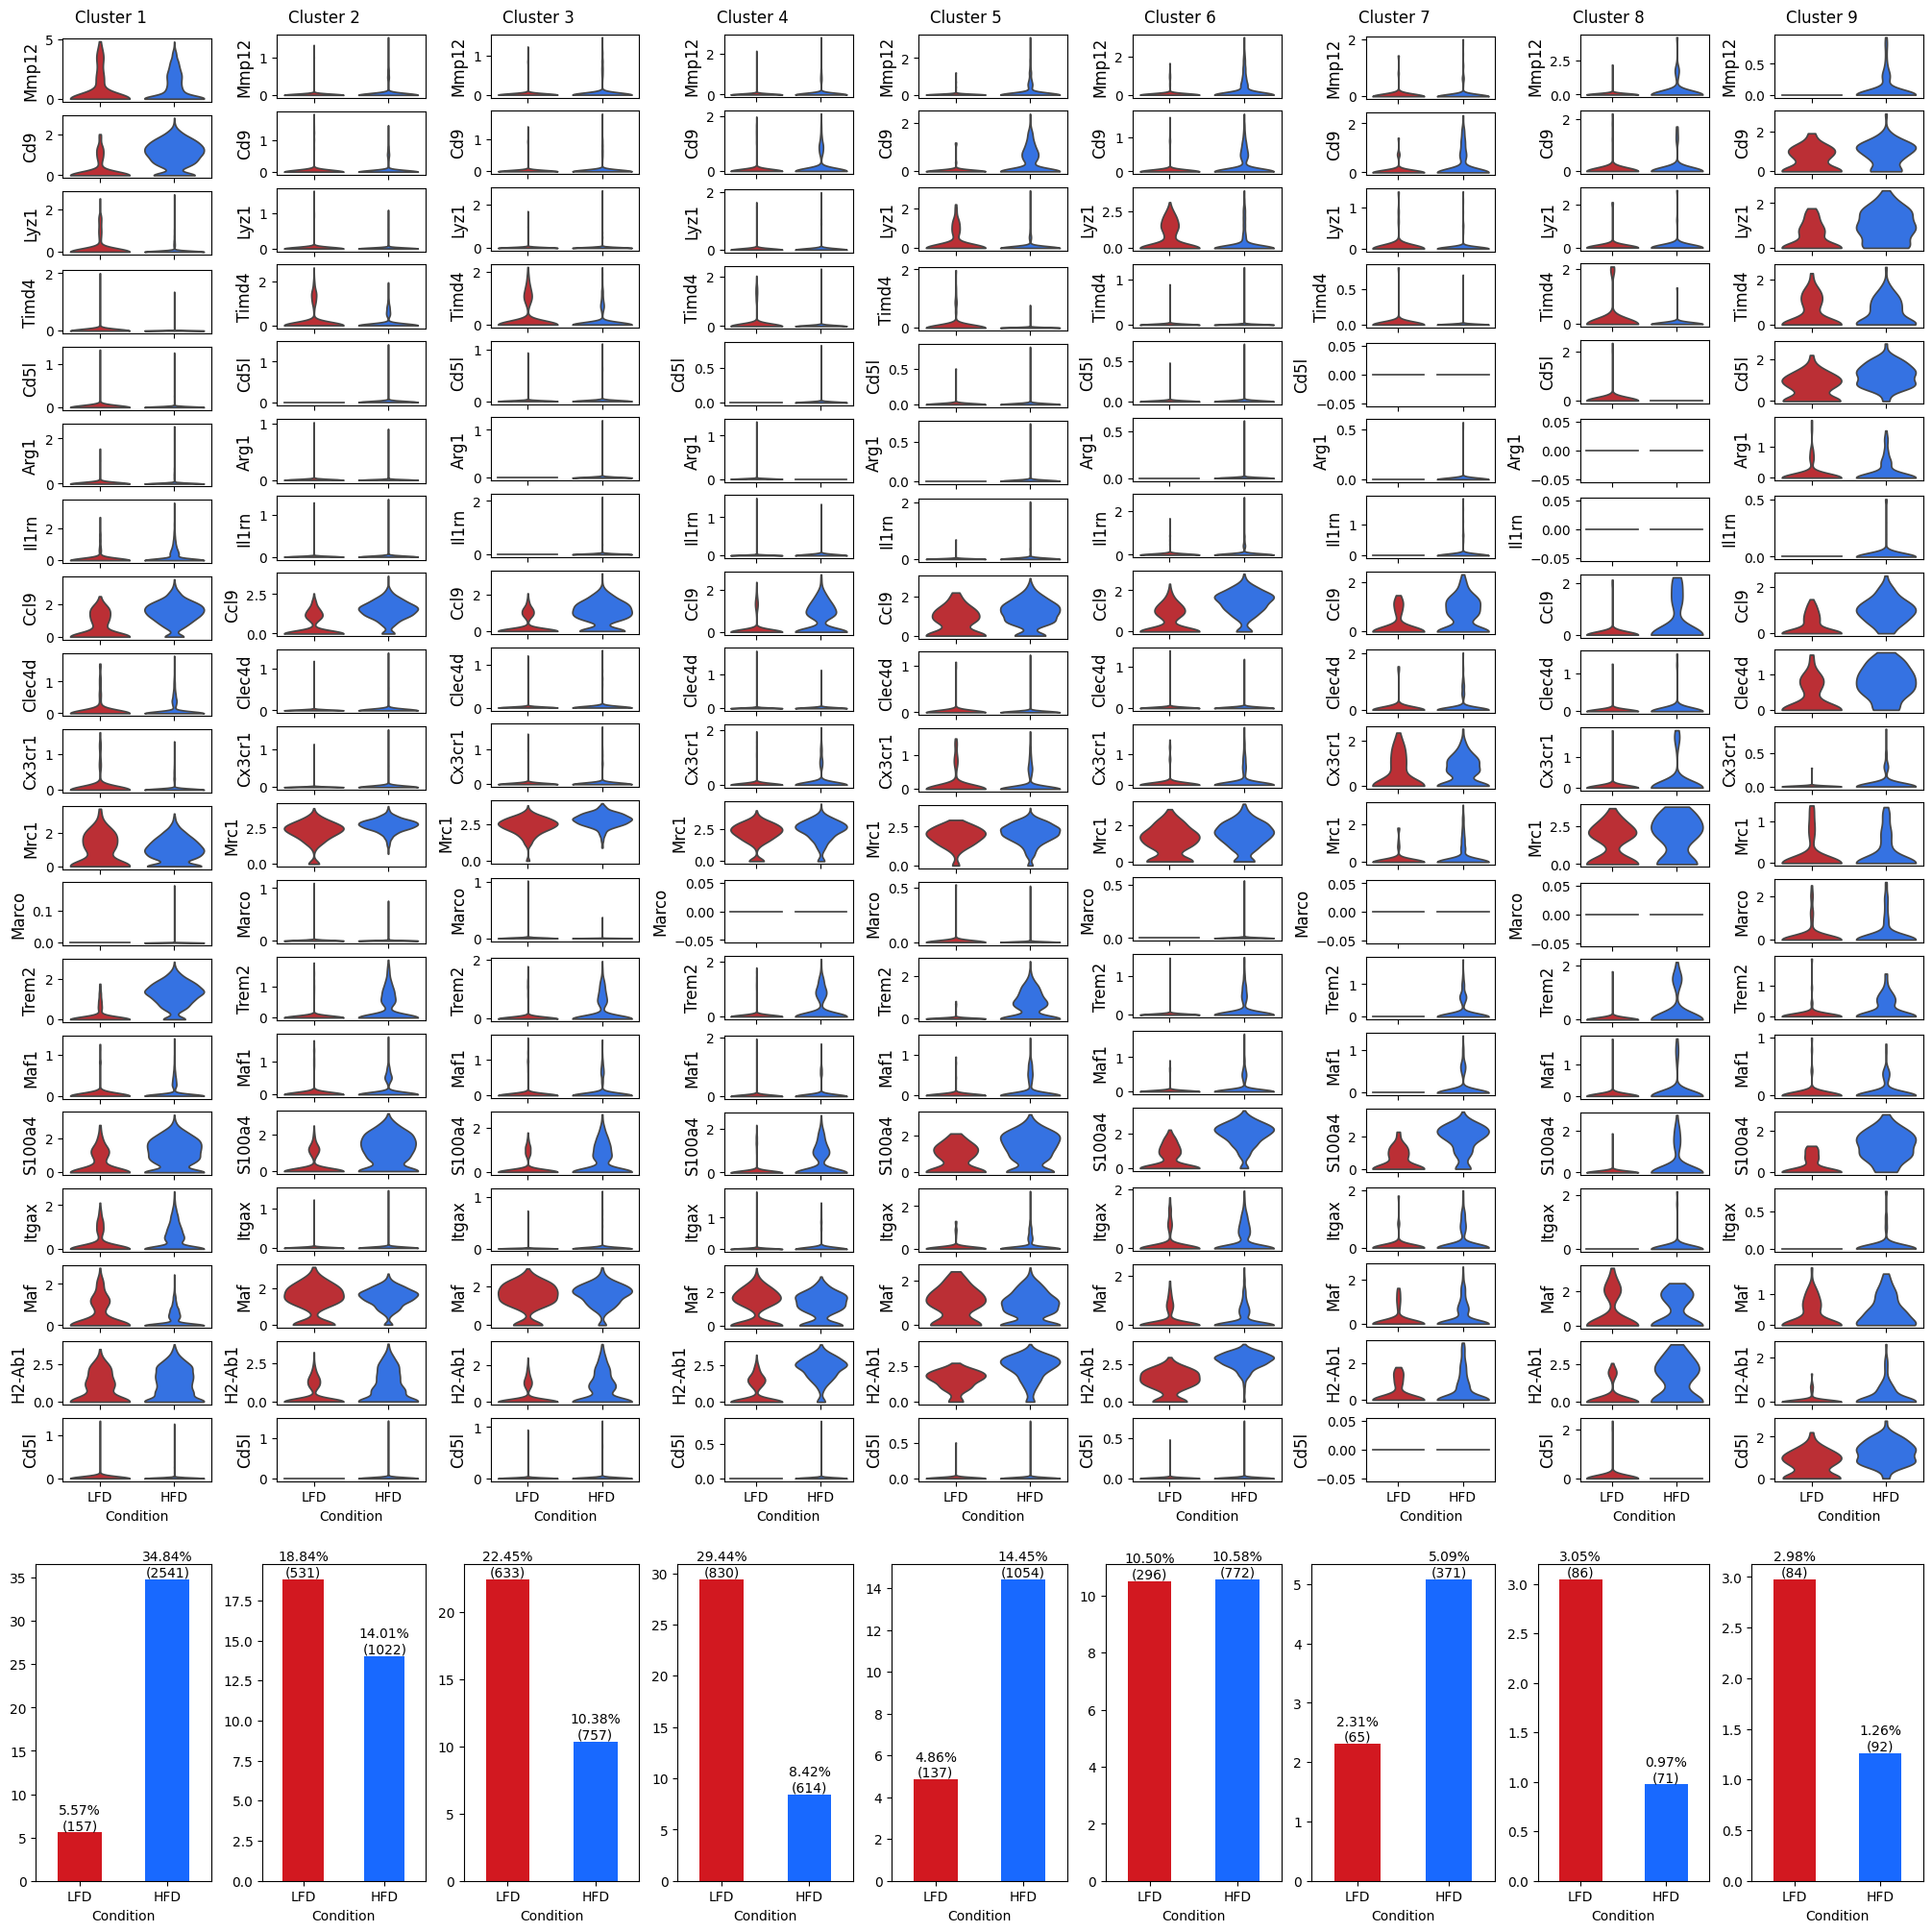

In [31]:
# violin plots, separated by condition & cluster
f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(
    ewat_macros, "Condition", "leiden_macro_group", spatial_informed_markers, f
)

In [ ]:
# DEG markers
f = plt.figure(figsize=(50, 10), layout="constrained")
sf = f.subfigures(1, 5)
clusters = adata_macros.obs["leiden_macro_group"].cat.categories
genes = [
    group.head(10).index.tolist()
    for name, group in sc.get.rank_genes_groups_df(
        adata_macros, group=None, key="de_macro"
    ).groupby()
]

# genes = [["Pecam1", "Fabp4", "Cdh5", "Cdh13", "Ptprb", "Adgrf5", "Mgll", "Etl4", "Gpihbp1", "Mecom"],
#         ["F13a1", "Rbpj", "Mrc1", "Maf", "Slc9a3r2", "Ctss", "Gas6", "Serinc3", "Fcgr2b", "Ap2a2"],
#         ["Lgals3", "Lipa", "Ctse", "Adam8", "Atp6v0d2", "Trem2", "Psap", "Plin2", "Mfsd12", "Ms4a6c"],
#         ["Jarid2", "Klf2", "Gsr", "Ccr2", "Ifitm6", "Arhgap26", "Plcb1", "Itgal", "Itga4", "Fam49b"],
#         ["Flnb", "Prg4", "Emilin2", "Thbs1", "Fn1", "Itga6", "Ssh2", "Alox15", "Ltbp1", "Itgam"]
# ]

for g, gene in enumerate(genes):
    plot_violinplot(adata_macros, gene, "leiden_macro_group", sf[g])

#### HFD vs LFD

In [ ]:
hfd_macros = adata_macros[adata_macros.obs["Condition"] == "HFD"].copy()
hfd_macros = hfd_macros[
    hfd_macros.obs["leiden_macro_group"].isin(["1", "2", "3", "5"])
]  # remove 4 since there's only 1 cell
lfd_macros = adata_macros[adata_macros.obs["Condition"] == "LFD"].copy()

In [ ]:
sc.tl.rank_genes_groups(
    hfd_macros,
    groupby="leiden_macro_group",
    key_added="de_macro",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

# del hfd_macros.uns['dendrogram_leiden_macro_group']
f, ax = plt.subplots(1, 1, figsize=(15, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    hfd_macros,
    groupby="leiden_macro_group",
    key="de_macro",
    standard_scale="var",
    n_genes=10,
    min_logfoldchange=2,
    ax=ax,
    title="HFD DEGs",
)

In [ ]:
sc.tl.rank_genes_groups(
    lfd_macros,
    groupby="leiden_macro_group",
    key_added="de_macro",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

del lfd_macros.uns["dendrogram_leiden_macro_group"]
f, ax = plt.subplots(1, 1, figsize=(15, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    lfd_macros,
    groupby="leiden_macro_group",
    key="de_macro",
    standard_scale="var",
    n_genes=10,
    min_logfoldchange=2,
    ax=ax,
    title="LFD DEGs",
)

### ORA Enrichment

In [ ]:
sources = ["GO:MF", "GO:CC", "KEGG", "REAC"]

GOterms = GO_Enrich(
    adata_macros,
    "leiden_fibro_group",
    "de_fibro",
    sources=sources,
    pval_cutoff=1e-5,
    log2fc_min=1,
)

figsizes = [(8, 12), (8, 14), (8, 8), (8, 10)]
for n, source in enumerate(sources):
    fig = plot_go_enrichment(
        df_dict=GOterms[source],
        pvalue_col="p_value",
        score_col="term_size",
        pvalue_threshold=0.05,
        rank_by="pvalue",
        top_n=15,
        use_log_pvalue=True,
        use_log_score=False,
        figsize=figsizes[n],
        database=source,
    )

    plt.show()

### GSEA

In [ ]:
run_GSEA = True

# get geneset info
ref_dir = os.path.join(REFDIR, "interactome")
gsea_sets = {
    "FIBRO_MSigDB-MH": os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M2-CP": os.path.join(ref_dir, "m2.cp.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M3": os.path.join(ref_dir, "m3.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M5-GO": os.path.join(ref_dir, "m5.go.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M7": os.path.join(ref_dir, "m7.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M8": os.path.join(ref_dir, "m8.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_CollecTRI": dc.op.collectri(organism="mouse"),
}

# run GSEA
if run_GSEA is True:
    for name, geneset in gsea_sets.items():
        if type(geneset) is str:
            GSEA_decoupler(adata_macros, name, geneset_dir=geneset)
        else:
            GSEA_decoupler(adata_macros, name, geneset=geneset)


# plot
f = plt.figure(figsize=(len(gsea_sets) * 8, 10), layout="constrained")
sf = f.subfigures(1, len(gsea_sets))
for name in gsea_sets.keys():
    plot_gsea(
        adata_macros,
        f"GSEA ({name})",
        f"{name}_score_ulm",
        "fibro_leiden_group",
        5,
        name,
    )

In [ ]:
score = dc.pp.get_obsm(adata, key=f"{name}_score_ulm")
sc.pl.embedding(
    score,
    basis="LocalMAP",
    color=["Maf", "cell_type", "Condition"],
    title=["Maf (TF) GSEA enrichment", "Cell Type", "Condition"],
    cmap="RdBu_r",
    vcenter=0,
)

### Save/Load

In [104]:
# save
annotation = "manDoublet-seuratV3-harmony-leiden_1-macro_leiden_0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "4_subclustered")
os.makedirs(savedir, exist_ok=True)
adata_macros.write(os.path.join(savedir, f"{annotation}.h5ad"))

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-leiden_1-macro_leiden_0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "4_subclustered")
adata_macros = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# relevant subsets
ewat_macros = adata_macros[adata_macros.obs["Sample Type"] == "eWAT"].copy()
ewat_macros = ewat_macros[ewat_macros.obs["leiden_fibro_group"] != "4"].copy()

lfd_ewat_macros = ewat_macros[ewat_macros.obs["Condition"] == "LFD"].copy()
hfd_ewat_macros = ewat_macros[ewat_macros.obs["Condition"] == "HFD"].copy()

# Gene Deep Dive (Arg1+)

In [ ]:
sc.pl.violin(
    adata_macros, ["Arg1"], groupby="leiden_macro", use_raw=False, layer="normalized"
)
sc.pl.embedding(adata_macros, basis=embedding, color=["Arg1"], cmap="BuPu")

In [ ]:
adata_macros.obs["Arg1+"] = (
    adata_macros[:, "Arg1"].layers["normalized"].toarray().flatten() > 0
)
print(adata_macros.obs["Arg1+"].sum())
adata_macros.obs["Arg1+"] = adata_macros.obs["Arg1+"].map({True: "High", False: "Low"})
sc.pl.embedding(
    adata_macros, basis=embedding, color=["Arg1+", "leiden_macro"], cmap="BuPu"
)

In [ ]:
sc.tl.rank_genes_groups(
    adata_macros,
    groupby="Arg1+",
    key_added="de_Arg1+_macro",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)
df = sc.get.rank_genes_groups_df(
    adata_macros, group="High", key="de_Arg1+_macro", pval_cutoff=0.001
)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8, 3), layout="constrained")
sc.pl.violin(
    adata_macros, ["Arg1"], groupby="Groups", use_raw=False, layer="normalized", ax=ax
)

In [ ]:
other_degs = adata_macros[:, df.head(30)["names"].to_list()].layers["normalized"]
arg1 = adata_macros[:, ["Arg1"]].layers["normalized"]

In [ ]:
def scatter_gene_comparison(
    adata, main_gene, genes_list, group_col, layer=None, ncols=5
):
    """Quick gene expression scatter plots colored by group."""
    # Setup
    main_expr = (
        adata[:, main_gene].layers[layer].toarray().flatten()
        if layer
        else adata[:, main_gene].X.toarray().flatten()
    )
    nrows = int(np.ceil(len(genes_list) / ncols))

    # Create plot
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(4 * ncols, 4 * nrows), layout="constrained"
    )
    axes = axes.flatten()

    # Plot each comparison
    for i, gene in enumerate(genes_list):
        gene_expr = (
            adata[:, gene].layers[layer].toarray().flatten()
            if layer
            else adata[:, gene].X.toarray().flatten()
        )
        for group in adata.obs[group_col].unique():
            mask = adata.obs[group_col] == group
            axes[i].scatter(
                gene_expr[mask], main_expr[mask], s=1, alpha=0.5, label=group
            )

        axes[i].set_xlabel(gene)
        axes[i].set_ylabel(main_gene if i % ncols == 0 else "")
        axes[i].spines[["top", "right"]].set_visible(False)
        axes[i].set_title(f"{main_gene} vs {gene}")
        if i == 0:
            axes[i].legend(frameon=True)

    # Clean up
    for ax in axes[len(genes_list) :]:
        ax.remove()
    return fig


fig = scatter_gene_comparison(
    adata,
    main_gene="Arg1",
    genes_list=df.head(30)["names"].to_list(),
    group_col="Condition",
    layer="normalized",
)

In [ ]:
name = "MSigDB-M3 Arg1+ only"
ref_dir = os.path.join(REFDIR, "interactome")
GSEA_decoupler(
    adata_macros,
    name,
    geneset_dir=os.path.join(ref_dir, "m3.all.v2025.1.Mm.symbols.gmt"),
)
plot_gsea(
    adata_macros,
    f"GSEA ({name})",
    f"{name}_score_ulm",
    "Arg1+",
    n_markers=10,
    flip=True,
)

# Save/Load

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-leiden_1-macro_leiden_0.5"
savedir = os.path.join(DATADIR, "processed", "single cell", "4_subclustered")
os.makedirs(savedir, exist_ok=True)
adata_fibros = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

In [5]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated-macro"
savedir = os.path.join(DATADIR, "processed", "single cell", "4_subclustered")
adata_macros = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# relevant subsets
ewat_macros = adata_macros[adata_macros.obs["Sample Type"] == "eWAT"].copy()
lfd_ewat_macros = ewat_macros[ewat_macros.obs["Condition"] == "LFD"].copy()
hfd_ewat_macros = ewat_macros[ewat_macros.obs["Condition"] == "HFD"].copy()